In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from syspy.skims import skims
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Preparation of the LoS tables
## Corrects footpaths in the LoS table
## Needs PT LoS table and footpaths

In [3]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [7]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

The only kind of all-walk connections between centroids should be direct connections without intermediate stops at PT nodes because these are always connected to access/egress links which have non-footpath properties.

Thus, footpaths already computed in prep2 will be parametrised with census based mean distances.

In [8]:
# Drop walking links that use access-egress links
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']!='walk']

In [9]:
# Use saved non-motorised paths, if they exist from a previous run
if os.path.exists(model_path + 'de_pt_los_non-motor/'):
    w = stepmodel.read_json(model_path + 'de_pt_los_non-motor')
    sm.pt_los = sm.pt_los.append(w.pt_los.loc[w.pt_los['route_type']=='walk']).reset_index(drop=True)
    print('Added walking paths from previous run')
    sm.to_json(model_path + 'de_pt_los',
               only_attributes=['pt_los'],
               encoding='utf-8')
    assert manual # break automation

In [10]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
index,,,,,,,,,,,,,,,,,,,,,
3035798,DE21F_0,DE934_2,"[rail_short, bus, rail_long]","[rs_34069, rs_34070, rs_34071, rs_34072, rs_34...",2,741214,1468,202,22980,3600,...,114.955371,114.955371,84.943819,84.943819,96.94844,102.95075,84.943819,90.946129,84.943819,84.943819


## Compute mean distances
Based on census data: mean population-weighted distance from origin centroid to every population cluster in the destination zone

In [5]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    print('No file with geometries found')
    import shapely.speedups
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)
    pop['FID'] = np.nan
    z = stepmodel.read_json(model_path + 'de_zones')
    shapely.speedups.enable
    for _, zone in tqdm(z.zones.iterrows(), total=z.zones.shape[0]):
        pop.loc[pop['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    pop.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

In [6]:
pop.sample()

,Einwohner,NUTS_ID,FID,geometry
375965,7,DE145,DE279_5,POINT (10.16846 48.51805)


In [11]:
# Build zone-connecting footpaths
foot = engine.ntlegs_from_centroids_and_nodes(
    ae.centroids,
    ae.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_bicycle_between_zones'],
    coordinates_unit=ae.coordinates_unit)
foot = foot.loc[foot['distance']<=params['access-egress_links']['bicycle_max_dist']]
foot = foot.loc[foot['distance']!=0]
foot.drop_duplicates(['a', 'b', 'time'], inplace=True)
print(len(foot))
foot.sample()

22196


,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
3857,DEA35_3,DEA5C_1,1,10834.793791,"LINESTRING (7.4118555 51.7396255, 7.496053 51....",access,5.204516,17,17,17.0,2294.426921


In [12]:
try:
    speed = foot['speed'].mean() # in km/h
except KeyError:
    speed = params['pt_access']['speed_bicycle']
foot = foot[['a', 'b']]
speed

17.0

In [13]:
# Build all columns of LoS table
foot['index'] = foot.index
foot['path'] = [(a,i,b) for a,i,b in zip(foot['a'], foot.index, foot['b'])]
foot.drop('index', axis=1, inplace=True)
foot = foot.rename(columns={'a': 'origin', 'b': 'destination'})
foot['link_path'] = [[] for _ in range(len(foot))]
for col in ['ntransfers', 'access_time', 'footpath_time',
            'in_vehicle_time', 'waiting_time',
            'boarding_time', 'time', 'length'] + [
    s.strip()+'_price' for s in params['general']['demand_segments'].split(';')
]:
    if col in sm.pt_los.columns:
        foot[col] = 0
foot['route_types'] = [('walk',) for _ in range(len(foot))]
foot['route_type'] = 'walk'

In [14]:
# Clean
foot = foot.loc[~(~(foot['origin'].str.startswith('DE')) |
                  ~(foot['origin'].str.startswith('DE')) |
                  (foot['origin']==foot['destination']))]
foot.drop_duplicates(subset=['origin', 'destination'], inplace=True)
foot.reset_index(drop=True, inplace=True)
foot.shape

(22193, 25)

In [15]:
foot.sample()

,origin,destination,path,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,...,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price,route_types,route_type
6738,DE11B_6,DE256_10,"(DE11B_6, 8973, DE256_10)",[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(walk,)",walk


In [16]:
# Calculate mean population-weighted distances
# from the origin centroid to all points in the destination zone
for ind, row in tqdm(foot.iterrows(), total=len(foot.index)):
    o = ae.centroids.loc[row['origin'], 'geometry']
    zone = pop.loc[pop['FID']==row['destination']]
    weighted_dist = [skims.get_distance_from_lon_lat_in_m(
        o.coords[0][0], o.coords[0][1], p['geometry'].coords[0][0], p['geometry'].coords[0][1])
                     * p['Einwohner'] for _, p in zone.iterrows()]
    foot.loc[ind, 'length'] = sum(weighted_dist) / zone['Einwohner'].sum()

100%|██████████████████████████████████████████████████████████████████████████| 22193/22193 [3:53:41<00:00,  1.58it/s]


<AxesSubplot:>

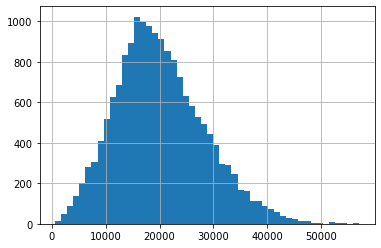

In [17]:
if manual: foot['length'].hist(bins=50)

In [18]:
# Replace NaN
foot.loc[foot['length'].isna(), 'length'] = foot.loc[foot['length'].notna(), 'length'].mean()

In [19]:
# Generate time in seconds
foot['time'] = foot['length'] / (speed / 3.6)
if 'footpath_time' in sm.pt_los.columns:
    foot['footpath_time'] = foot['time']

<AxesSubplot:>

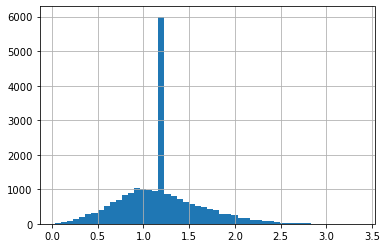

In [20]:
if manual: (foot['time']/3600).hist(bins=50) # in h

## Save

In [21]:
# Make DataFrame lighter
cols = ['length'] + [col for col in foot.columns if col[-4:]=='time']
foot[cols] = foot[cols].astype(int)

In [22]:
# Add to LoS table
sm.pt_los = sm.pt_los.append(foot).reset_index(drop=True)

In [23]:
sm.pt_los.loc[sm.pt_los['route_type']=='walk'].sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price,path
10382776,DE734_6,DE734_8,"(walk,)",[],0,15056,0,3188,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(DE734_6, 7852, DE734_8)"


In [24]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 8/8 [03:10<00:00, 23.80s/it]


In [25]:
# Save only the walking part
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']=='walk']
sm.to_json(model_path + 'de_pt_los_non-motor',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.93it/s]
